# Анализ телефонных звонков и клиентских продаж Банка

## Часть 0: Введение  

### Обзор  
Датасет содержит информацию о клиентах, их социально-демографических характеристиках, звонках и результатах взаимодействия с сотрудниками банка.  

**Метаданные (основные поля):**  
- `customer_id` — уникальный идентификатор клиента  
- `age`, `gender_cd` — возраст и пол клиента  
- `region_size` — тип региона проживания (город/село)  
- `auto_flg`, `traveler_flg`, `entrepreneur_flg` — наличие автомобиля, статус путешественника, предпринимателя  
- `child_amt` — количество детей  
- `realty_type` — наличие недвижимости  
- `product_cd`, `functional_cd` — продукт и функциональное направление  
- `state_talk_time_sec` — длительность разговора (в секундах)  
- `wo_hit_status_result_desc` — результат звонка (успешно / отказ)  
- `wo_hit_status_reason_desc` — причина отказа/успеха  
- `employee_id`, `emp_age`, `emp_gender_cd` — данные сотрудника, совершившего звонок  

**Размер:** 18 691 записей, 28 колонок.  

### Допущения  
- Данные могут содержать пропуски (например, `region_size`, `income`, семейное положение сотрудников).  
- Часть признаков (`predicted_income`) может содержать ошибки (есть отрицательные значения).  
- Не все клиенты имели подтвержденный доход.  
- Важно учитывать баланс классов в целевой переменной (успешные звонки vs отказы).  

### Вопросы для исследования  
1. Какие факторы влияют на успешность звонка (например, возраст клиента, тип региона, наличие детей)?  
2. Как связаны характеристики сотрудников (возраст, опыт работы) с результатами звонков?  
3. Какие продукты (`product_cd`) чаще всего продаются успешно?  
4. Как длительность разговора влияет на вероятность успеха?  
5. Есть ли различия между группами клиентов (город/село, авто/без авто)?  

## Часть 1: Импорт библиотек и загрузка данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
df = pd.read_csv("D:/Anaconda/sale_tasks_dataset.csv")
df.head(10)

,customer_id,age,gender_cd,region_size,foreign_flg,entrepreneur_flg,auto_flg,traveler_flg,partnership_flg,child_amt,...,state_talk_time_sec,wo_hit_status_result_desc,wo_hit_status_reason_desc,employee_id,emp_age,emp_gender_cd,emp_children_cnt,emp_work_months_cnt,emp_citizenship_country_cd,emp_marital_status_cd
0,422206773,58.0,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,67.0,"Дозвон, Отказ",Перезвонит самостоятельно позднее,142052.0,30,W,NaN,1,NaN,NaN
1,348648289,44.0,M,rural,0.0,0.0,0.0,0.0,1.0,1.0,...,151.0,"Дозвон, Отказ",Другое,7004.0,36,W,NaN,2,RUS,NaN
2,345496995,23.0,F,town,0.0,0.0,1.0,0.0,1.0,0.0,...,68.0,"Дозвон, Успешно",Назначена встреча,80760.0,52,W,NaN,6,NaN,NaN
3,182783192,34.0,M,town,0.0,0.0,0.0,0.0,0.0,0.0,...,738.0,"Дозвон, Успешно",Обещал утилизироваться самостоятельно,158672.0,22,NaN,NaN,8,NaN,NaN
4,138498254,30.0,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39.0,"Дозвон, Отказ",Переведен в банк,14462.0,51,W,NaN,7,NaN,NaN
5,64946855,31.0,M,town,0.0,0.0,0.0,0.0,1.0,0.0,...,36.0,"Дозвон, Отказ",Отказ прослушать предложение,184241.0,43,W,NaN,6,RUS,UNM
6,516320897,34.0,F,town,0.0,0.0,0.0,0.0,1.0,0.0,...,38.0,"Дозвон, Отказ",Страхуется в своей СК,106508.0,74,M,NaN,1,RUS,NaN
7,37214043,55.0,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.0,"Дозвон, Отказ",Другое (нестандартная ситуация),14462.0,51,W,NaN,7,NaN,NaN
8,148619460,67.0,F,town,0.0,0.0,0.0,0.0,1.0,0.0,...,24.0,"Дозвон, Отказ",Отказ прослушать предложение,104002.0,46,W,NaN,10,NaN,NaN
9,67061355,41.0,F,urban,0.0,1.0,1.0,0.0,1.0,1.0,...,22.0,"Дозвон, Отказ",Другое,209308.0,20,W,NaN,7,NaN,NaN


## Часть 2: Разведочный анализ данных (EDA)

### 2.1. Общая информация и описание числовых колонок

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18691 entries, 0 to 18690
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_id                 18691 non-null  int64  
 1   age                         18509 non-null  object 
 2   gender_cd                   18433 non-null  object 
 3   region_size                 11402 non-null  object 
 4   foreign_flg                 11402 non-null  float64
 5   entrepreneur_flg            11402 non-null  float64
 6   auto_flg                    11402 non-null  float64
 7   traveler_flg                11402 non-null  float64
 8   partnership_flg             11402 non-null  float64
 9   child_amt                   11402 non-null  float64
 10  realty_type                 11402 non-null  object 
 11  segment_cd                  11402 non-null  object 
 12  bundle_nm                   4703 non-null   object 
 13  confirmed_income            140

In [ ]:
df.describe()

,customer_id,foreign_flg,entrepreneur_flg,auto_flg,traveler_flg,partnership_flg,child_amt,confirmed_income,predicted_income,state_talk_time_sec,employee_id,emp_age,emp_children_cnt,emp_work_months_cnt
count,1.869100e+04,11402.000000,11402.000000,11402.000000,11402.000000,11402.000000,11402.000000,1407.000000,4.087000e+03,18543.000000,18691.000000,18691.000000,86.000000,18691.000000
mean,3.166681e+08,0.009647,0.138309,0.501666,0.019558,0.790475,0.377741,15370.475146,7.203861e+06,86.350105,163220.261944,35.617944,1.151163,5.401263
std,1.488096e+08,0.097751,0.345239,0.500019,0.138482,0.406987,0.664226,10324.590776,4.594889e+08,127.011570,78054.113022,13.480531,1.367845,3.483958
min,1.423600e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7823.500000,-6.274500e+03,0.000000,871.000000,18.000000,0.000000,0.000000
25%,1.828957e+08,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,9871.190000,1.282350e+04,24.000000,109957.000000,23.000000,0.000000,2.000000
50%,3.436865e+08,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,12823.500000,1.492120e+04,46.000000,180298.000000,33.000000,0.000000,6.000000
75%,4.334274e+08,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,17013.335000,1.790127e+04,99.000000,224828.000000,46.000000,3.000000,8.000000
max,6.499757e+08,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,147128.410000,2.937498e+10,2671.000000,305477.000000,96.000000,3.000000,11.000000


### 2.2. Целевая переменная
Рассматриваем распределение `wo_hit_status_result_desc`.

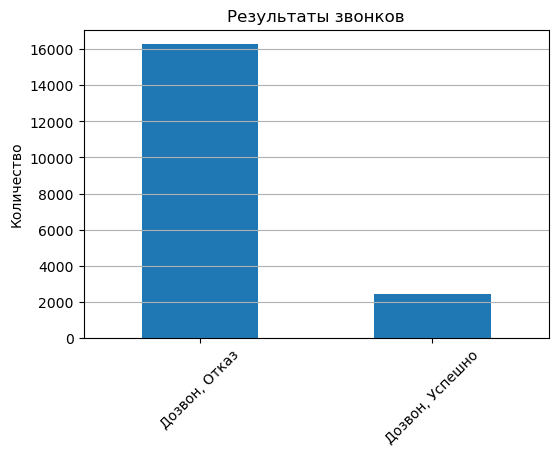

In [ ]:
success_counts = df["wo_hit_status_result_desc"].value_counts()
plt.figure(figsize=(6, 4))
success_counts.plot(kind="bar")
plt.title("Результаты звонков")
plt.xlabel("")
plt.ylabel("Количество")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

### 2.3. Пропуски в данных

emp_children_cnt              18605
confirmed_income              17284
emp_marital_status_cd         14825
predicted_income              14604
bundle_nm                     13988
emp_citizenship_country_cd    12487
realty_type                    7289
entrepreneur_flg               7289
region_size                    7289
segment_cd                     7289
foreign_flg                    7289
child_amt                      7289
partnership_flg                7289
traveler_flg                   7289
auto_flg                       7289
emp_gender_cd                  2180
gender_cd                       258
age                             182
state_talk_time_sec             148
dtype: int64

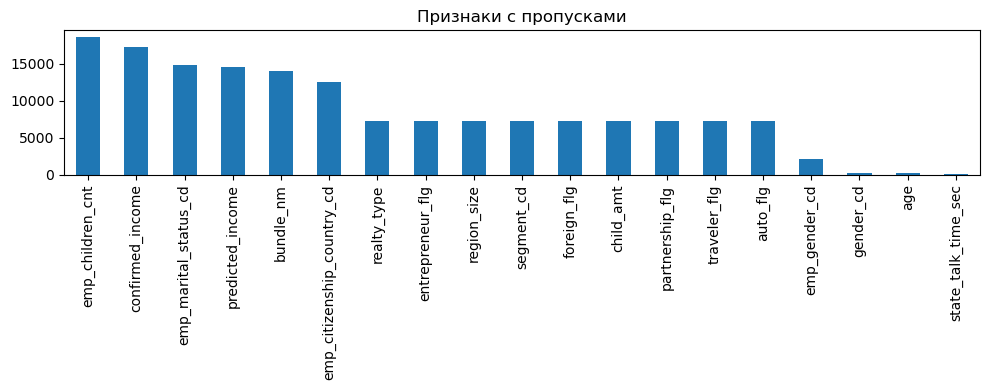

In [ ]:
missing = df.isna().sum().sort_values(ascending=False)
display(missing[missing>0])
missing[missing>0].plot(kind='bar', figsize=(10,4))
plt.title('Признаки с пропусками')
plt.tight_layout()
plt.show()

### 2.4. Числовые признаки

#### 2.4.0 Подготовка признака "Возраст"
Приводим возраст клиентов к числовому формату.

In [ ]:
df["age"] = pd.to_numeric(df["age"], errors="coerce")
df.head(10)

,customer_id,age,gender_cd,region_size,foreign_flg,entrepreneur_flg,auto_flg,traveler_flg,partnership_flg,child_amt,...,state_talk_time_sec,wo_hit_status_result_desc,wo_hit_status_reason_desc,employee_id,emp_age,emp_gender_cd,emp_children_cnt,emp_work_months_cnt,emp_citizenship_country_cd,emp_marital_status_cd
0,422206773,58.0,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,67.0,"Дозвон, Отказ",Перезвонит самостоятельно позднее,142052.0,30,W,NaN,1,NaN,NaN
1,348648289,44.0,M,rural,0.0,0.0,0.0,0.0,1.0,1.0,...,151.0,"Дозвон, Отказ",Другое,7004.0,36,W,NaN,2,RUS,NaN
2,345496995,23.0,F,town,0.0,0.0,1.0,0.0,1.0,0.0,...,68.0,"Дозвон, Успешно",Назначена встреча,80760.0,52,W,NaN,6,NaN,NaN
3,182783192,34.0,M,town,0.0,0.0,0.0,0.0,0.0,0.0,...,738.0,"Дозвон, Успешно",Обещал утилизироваться самостоятельно,158672.0,22,NaN,NaN,8,NaN,NaN
4,138498254,30.0,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39.0,"Дозвон, Отказ",Переведен в банк,14462.0,51,W,NaN,7,NaN,NaN
5,64946855,31.0,M,town,0.0,0.0,0.0,0.0,1.0,0.0,...,36.0,"Дозвон, Отказ",Отказ прослушать предложение,184241.0,43,W,NaN,6,RUS,UNM
6,516320897,34.0,F,town,0.0,0.0,0.0,0.0,1.0,0.0,...,38.0,"Дозвон, Отказ",Страхуется в своей СК,106508.0,74,M,NaN,1,RUS,NaN
7,37214043,55.0,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.0,"Дозвон, Отказ",Другое (нестандартная ситуация),14462.0,51,W,NaN,7,NaN,NaN
8,148619460,67.0,F,town,0.0,0.0,0.0,0.0,1.0,0.0,...,24.0,"Дозвон, Отказ",Отказ прослушать предложение,104002.0,46,W,NaN,10,NaN,NaN
9,67061355,41.0,F,urban,0.0,1.0,1.0,0.0,1.0,1.0,...,22.0,"Дозвон, Отказ",Другое,209308.0,20,W,NaN,7,NaN,NaN


#### 2.4.1 Распределение клентов по возрасту

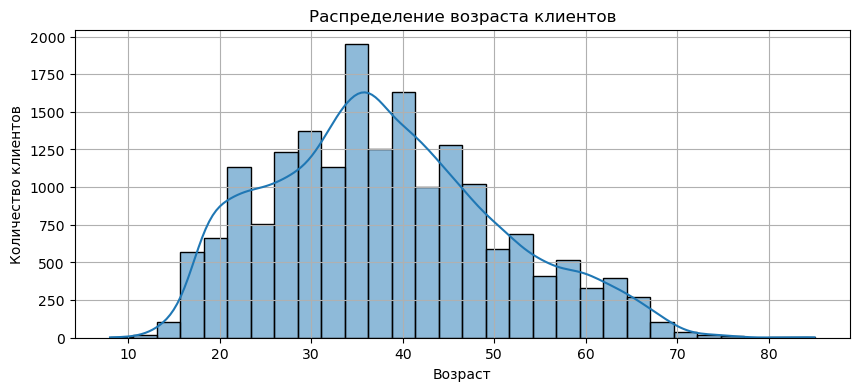

In [ ]:
plt.figure(figsize=(10, 4))
sns.histplot(df["age"].dropna(), bins=30, kde=True)
plt.title("Распределение возраста клиентов")
plt.xlabel("Возраст")
plt.ylabel("Количество клиентов")
plt.grid(True)
plt.show()

#### 2.4.2 Время разговора vs результат

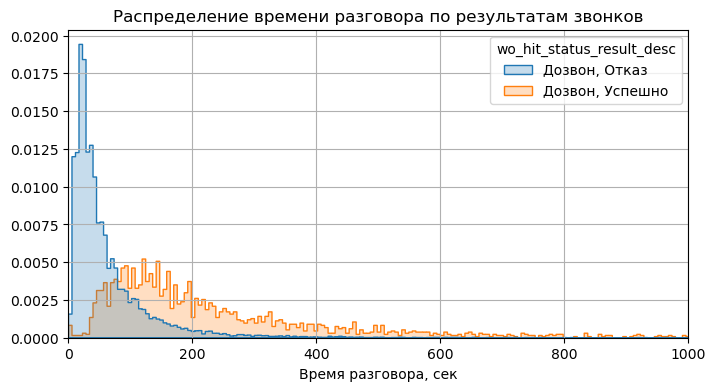

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x="state_talk_time_sec", hue="wo_hit_status_result_desc",
             element="step", stat="density", common_norm=False)
plt.title("Распределение времени разговора по результатам звонков")
plt.xlabel("Время разговора, сек")
plt.ylabel("")
plt.xlim(0, 1000)
plt.grid(True)
plt.show()

### 2.5. Категориальные признаки

#### 2.5.1 Успешность звонков (общая)

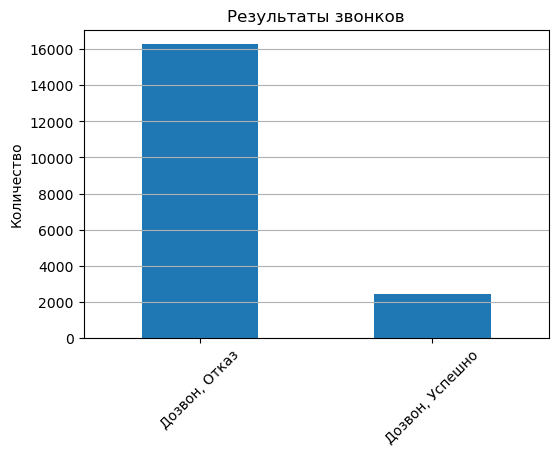

In [ ]:
success_counts = df["wo_hit_status_result_desc"].value_counts()
plt.figure(figsize=(6, 4))
success_counts.plot(kind="bar")
plt.title("Результаты звонков")
plt.xlabel("")
plt.ylabel("Количество")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

#### 2.5.2 Успешность по полу клиента

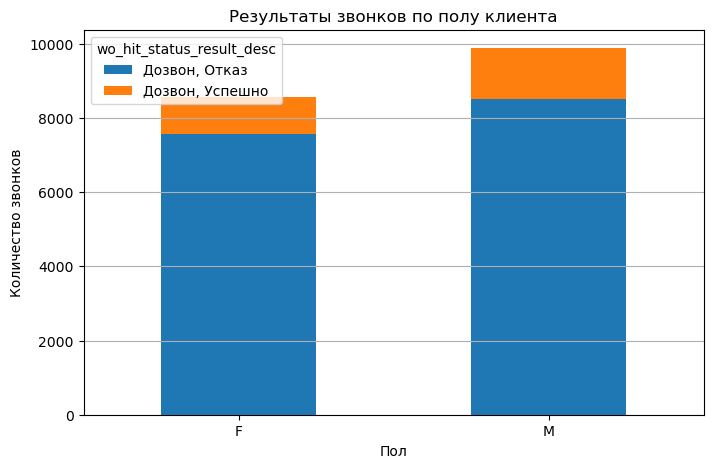

In [ ]:
gender_success = df.pivot_table(index="gender_cd", columns="wo_hit_status_result_desc", aggfunc="size", fill_value=0)
gender_success.plot(kind="bar", stacked=True, figsize=(8, 5))
plt.title("Результаты звонков по полу клиента")
plt.xlabel("Пол")
plt.ylabel("Количество звонков")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

### 2.6. Корреляции числовых признаков с таргетом

Бинаризуем таргет: 1 — успешно, 0 — нет

In [ ]:
df['target_success'] = df['wo_hit_status_result_desc'].astype(str).str.contains('усп', case=False, na=False).astype(int)

Корреляции(числовые)

In [ ]:
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cols_to_plot = [c for c in num_cols if c not in ['customer_id']]
corr_to_target = df[cols_to_plot + ['target_success']].corr(numeric_only=True)['target_success'].drop('target_success').sort_values(key=lambda s: s.abs(), ascending=False)
corr_to_target.head(15)

state_talk_time_sec    0.481253
emp_children_cnt      -0.324194
employee_id           -0.145394
foreign_flg            0.092563
emp_age                0.057573
partnership_flg       -0.034684
auto_flg              -0.032260
age                   -0.022803
child_amt              0.007976
traveler_flg          -0.007356
predicted_income      -0.005572
entrepreneur_flg      -0.003934
emp_work_months_cnt    0.003302
confirmed_income      -0.002856
Name: target_success, dtype: float64

### 2.6.1 Тепловая карта для топ-15

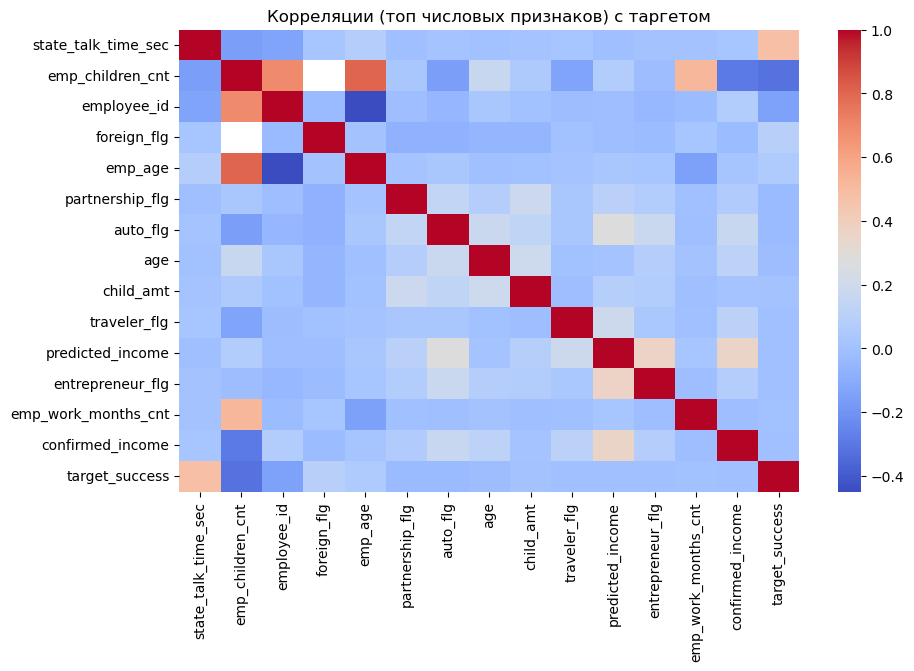

In [ ]:
top_num = corr_to_target.abs().head(15).index.tolist()
plt.figure(figsize=(10,6))
sns.heatmap(df[top_num + ['target_success']].corr(), annot=False, cmap='coolwarm')
plt.title('Корреляции (топ числовых признаков) с таргетом')
plt.show()

## Вывод

1. **Возраст клиентов**  
   - Основная масса клиентов находится в диапазоне **25–45 лет**.  
   - Распределение похоже на нормальное, но со сдвигом в сторону 30–35 лет (пик).  
   - Клиентов старше 60 лет заметно меньше.  

2. **Успешность звонков (общая)**  
   - Большинство звонков завершается **отказом**.  
   - Доля успешных звонков составляет примерно **15–20%** от общего числа.  
   - Баланс классов сильно смещён в сторону «Отказ», что важно учитывать при моделировании.  

3. **Пол клиентов**  
   - Количество звонков к мужчинам и женщинам примерно одинаковое.  
   - Доля успешных звонков у женщин немного ниже, чем у мужчин.  
   - Различие не критическое, но заметно на графиках.  

4. **Время разговора**  
   - Успешные звонки в среднем **длиннее**, чем неуспешные.  
   - Отказы чаще происходят на коротких звонках (до 50–100 секунд).  
   - Успешные звонки имеют более «растянутое» распределение времени разговора.